<a href="https://colab.research.google.com/github/Ankita-chouhan-github/EDA-Capstone-project/blob/main/NYC_Taxi_Trip_Time_Prediction_(Capstone_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**NYC Taxi Trip Price Prediction : Predicting total ride duration of taxi trips in New York City**

**Business Context**

your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers and several other variables.

In [ ]:
# Importing the Libraries
import numpy as np
import pandas as pd
from numpy import math
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt

!pip install shap==0.40.0
import shap 
import graphviz
sns.set_style('darkgrid') 

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Import from CSV file to pandas dataframe
NYC_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Regression Capstone Project/NYC Taxi Data.csv')

#**Exploratory Data Analysis**


---



Exploring data to understand what it contains and in which format and how much transformation we need to do to derive meanigful conclusions and predictions from the given data

In [ ]:
NYC_df.shape

(1458644, 11)

In [ ]:
NYC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


There are no null values in the data. 

In [ ]:
NYC_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

### **Feature details:**


* id - a unique identifier for each trip

* vendor_id - a code indicating the provider associated with the trip record

* pickup_datetime - date and time when the meter was engaged

* dropoff_datetime - date and time when the meter was disengaged

* passenger_count - the number of passengers in the vehicle (driver entered value)

* pickup_longitude - the longitude where the meter was engaged

* pickup_latitude - the latitude where the meter was engaged

* dropoff_longitude - the longitude where the meter was disengaged

* dropoff_latitude - the latitude where the meter was disengaged

* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

* Categorizing the features :

**Let's divide features into categories:**

* Geographical: pickup_longitude , pickup_latitude , dropoff_longitude , dropoff_latitude

* Time related: pickup_datetime, dropoff_datetime

* Identifier: id(not useful for analysis)

* Others: vendor_id, passenger_count, store_and_fwd_flag



In [ ]:
NYC_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
NYC_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
NYC_df.shape

(1458644, 11)

In [ ]:
NYC_df.drop_duplicates(inplace=True)
NYC_df.shape

(1458644, 11)

* NO duplicates Values were found in the dataset
* There are approximately 1.5 million rows in our data and 11 rows.
* There are no null values in our data.


In [ ]:
NYC_df['trip_duration'].isnull().sum()

0

In [ ]:
NYC_df['passenger_count'].value_counts().reset_index().sort_values(by='index')

,index,passenger_count
6,0,60
0,1,1033540
1,2,210318
3,3,59896
5,4,28404
2,5,78088
4,6,48333
7,7,3
9,8,1
8,9,1


* There are 60 rides in which there are 0 passengers so we create a new dataframe which contains only rows with atleast 1 passenger.

In [ ]:
NYC_df = NYC_df[NYC_df['passenger_count']!=0]

In [ ]:
NYC_df['passenger_count'].value_counts().reset_index().sort_values(by='index')

,index,passenger_count
0,1,1033540
1,2,210318
3,3,59896
5,4,28404
2,5,78088
4,6,48333
6,7,3
8,8,1
7,9,1


In [ ]:
NYC_df['pickup_datetime'][0]

'2016-03-14 17:24:55'

In [ ]:
# Converting time stamp to date time format to fetch other details from it
NYC_df['pickup_datetime']=pd.to_datetime(NYC_df['pickup_datetime'])
NYC_df['dropoff_datetime']=pd.to_datetime(NYC_df['dropoff_datetime'])
NYC_df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


##Feature Creation for EDA

Now, let us extract and create new features from this datetime features we just created.

In [ ]:
# pickup_weekday and dropoff_weekday will contain the name of
# the day on which the ride was taken

NYC_df['pickup_weekday']= NYC_df['pickup_datetime'].dt.day_name()

NYC_df['dropoff_weekday']= NYC_df['dropoff_datetime'].dt.day_name()

In [ ]:
# pickup_weekday_num which will contain the day number 
# instead of characters with Monday = 0 and sunday = 6
NYC_df['pickup_weekday_num']= NYC_df['pickup_datetime'].dt.weekday

In [ ]:
# pickup_hour with an hour of the day in the 24-hour format
NYC_df['pickup_hour']= NYC_df['pickup_datetime'].dt.hour

In [ ]:
# pickup_month with month number with January=1 and December=12
NYC_df['month']= NYC_df['pickup_datetime'].dt.month

We saw in our dataset that we have coordinates in the form of longitude and latitude for pickup and dropoff. But, we can’t really gather any insights or draw conclusions from that. So, the most obvious feature that we can extract from this is distance. Let us do that.

In [ ]:
from geopy.distance import great_circle

In [ ]:
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [ ]:
NYC_df['distance'] = NYC_df.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

In [ ]:
NYC_df['speed'] = (NYC_df.distance/(NYC_df.trip_duration/3600))

In [ ]:
NYC_df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_weekday                object
dropoff_weekday               object
pickup_weekday_num             int64
pickup_hour                    int64
month                          int64
distance                     float64
speed                        float64
dtype: object

Now we will define a function that will let us determine what time of the day the ride was taken.

We have reated four parts of time:-

**1. Morning** (from 6:00 AM to 11:59 AM)

**2. Afternonn** (from 12 noon to 3:59 PM)

**3. Evening** (from 4:00 PM to 9:59 PM)

**4. Late Night** (from 10:00 PM to 5:59 AM)

In [ ]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [ ]:
NYC_df['pickup_timeofday']=NYC_df['pickup_hour'].apply(time_of_day)

In [ ]:
NYC_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,distance,speed,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,17,3,1.498523,11.856445,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,6,1.805510,9.803673,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,11,1,6.385108,10.822216,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,19,4,1.485501,12.465739,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,13,3,1.188590,9.836608,Afternoon


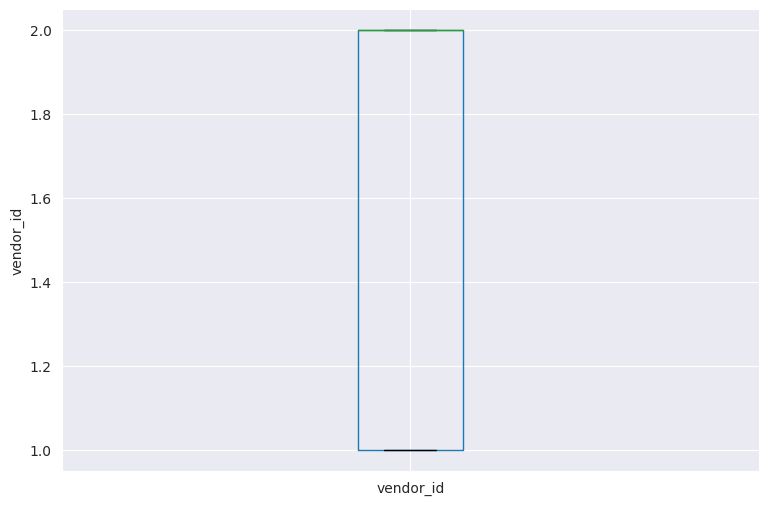

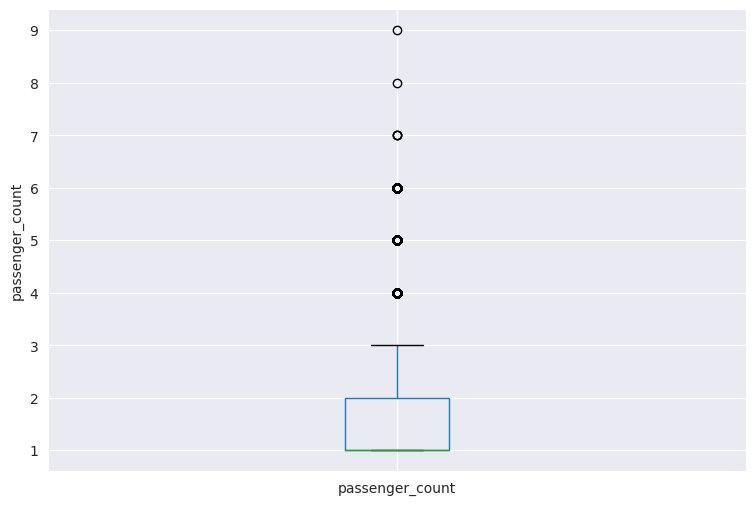

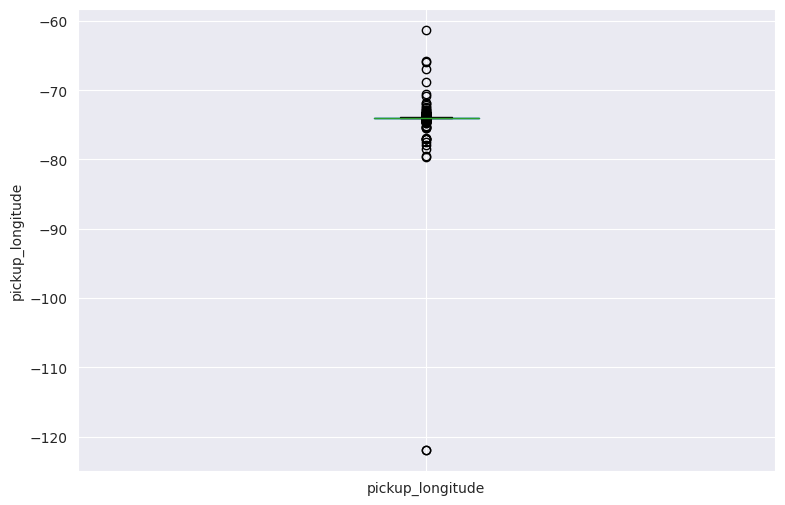

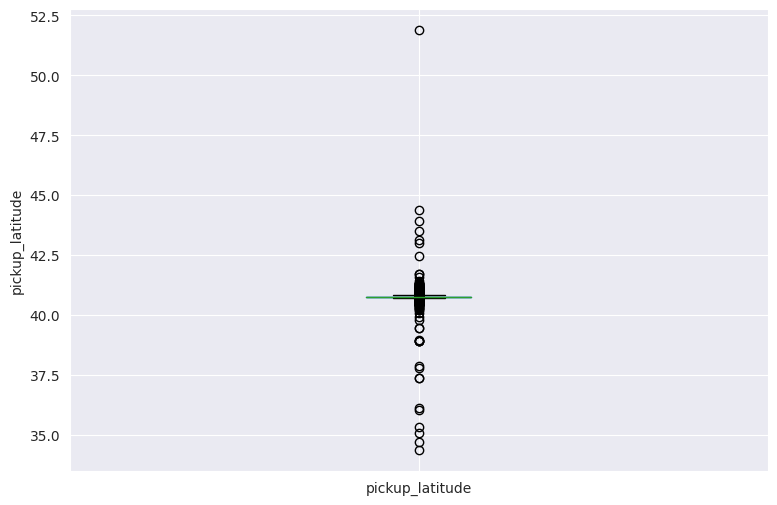

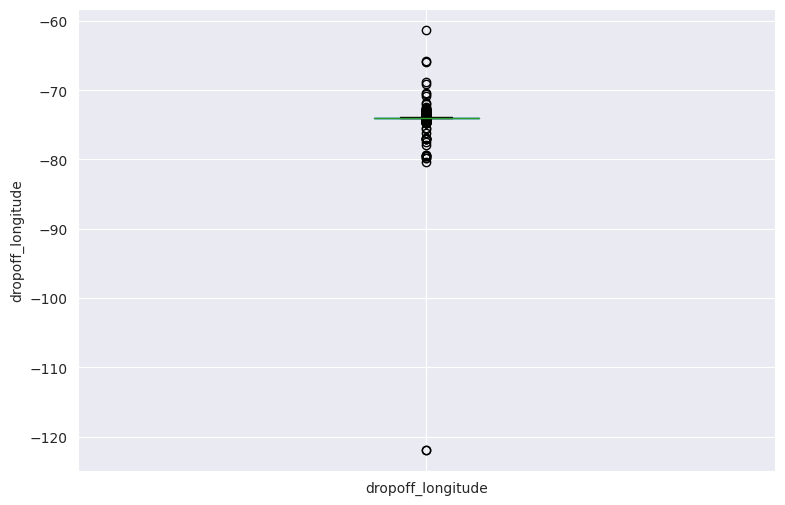

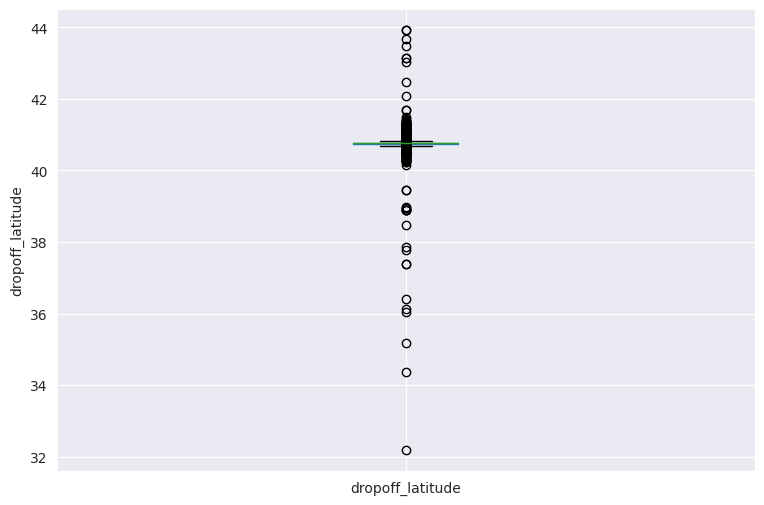

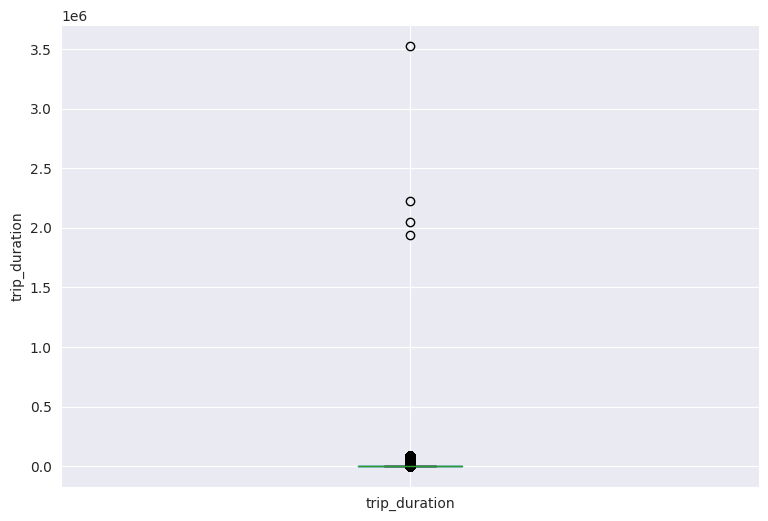

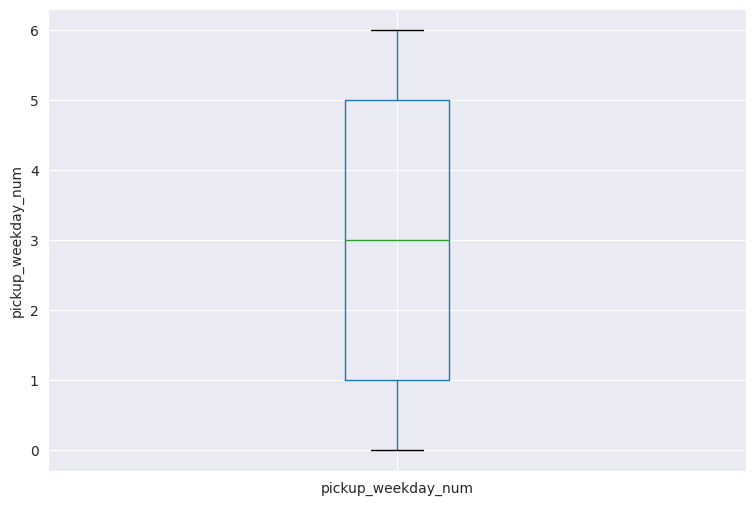

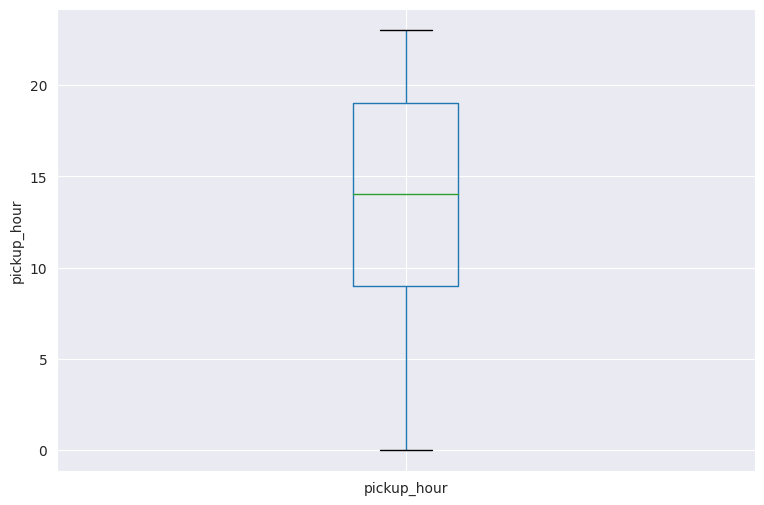

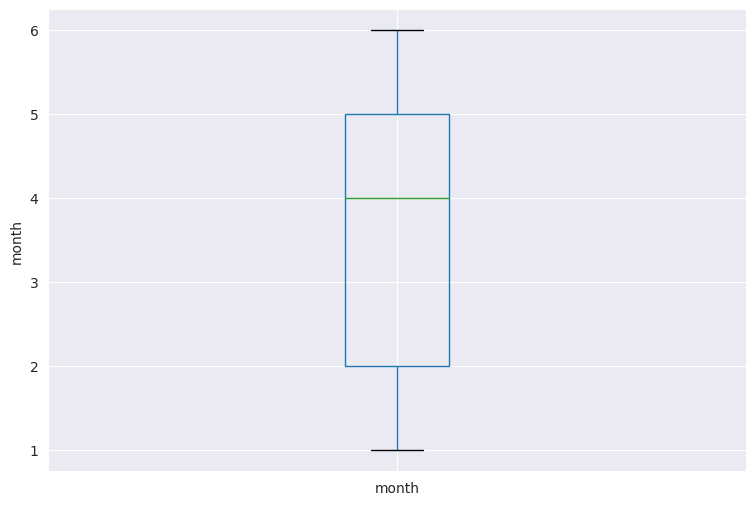

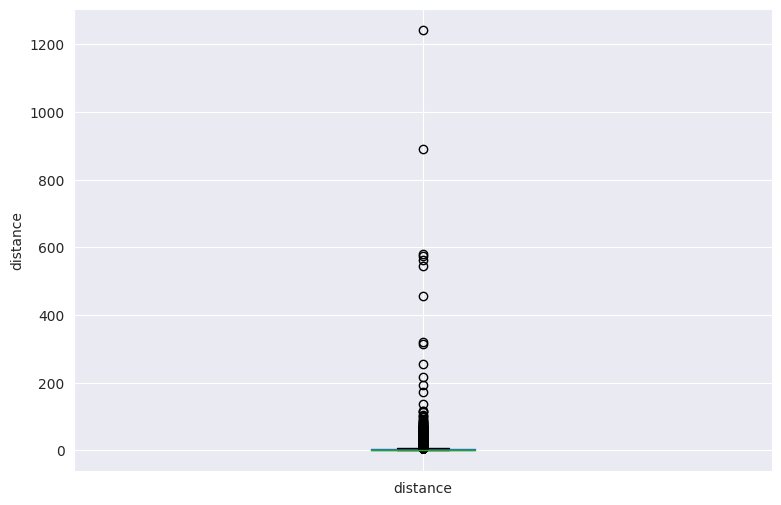

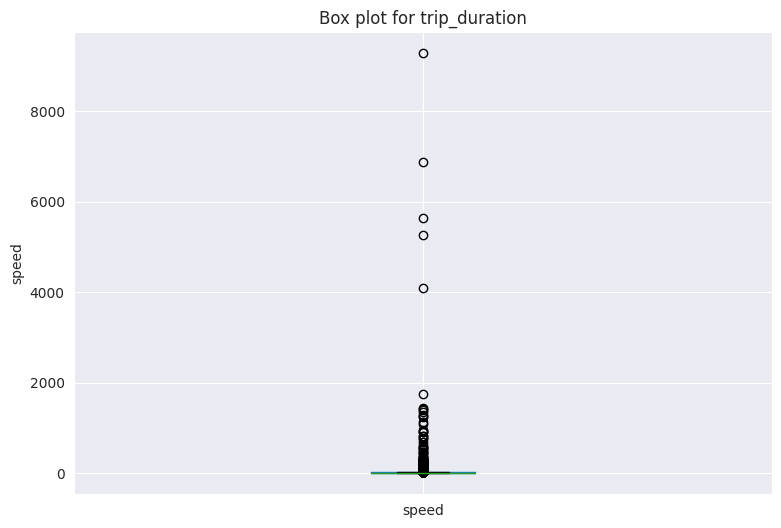

In [ ]:
# plot a boxplot for the label by each numerical feature  
for col in NYC_df.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  NYC_df.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.title("Box plot for trip_duration")
plt.show()

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.


##**Univariate Analysis**


---



Our target variable trip_duration has alot of outliers

Checking consitency of trip_duration

from the box plot we see that there are few outlier having very large value. we have to remove those outlier. but first let check the consitency of feature "trip duration". 

Text(0.5, 0, 'Trip Duration')

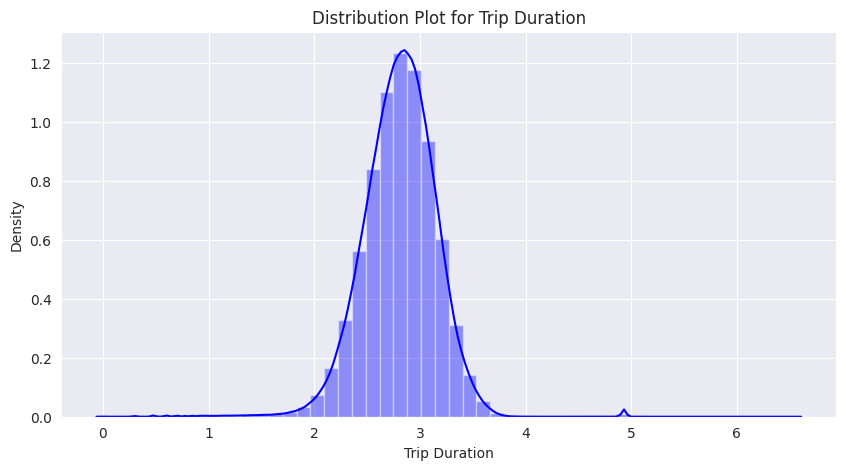

In [ ]:
# Dependent variable is 'trip_duration'
plt.figure(figsize=(10,5))
sns.distplot(np.log10(NYC_df['trip_duration']),
             color='b').set(title='Distribution Plot for Trip Duration')
plt.xlabel('Trip Duration')

* We can see it is a normally distributed plot




Calculating 0-100th percentile to find a correct percentile value for removal of outliers.

In [ ]:
for i in range(0,100,10):
  duration = NYC_df['trip_duration'].values
  duration = np.sort(duration)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ", duration[-1])

0 percentile value is 1
10 percentile value is 245
20 percentile value is 348
30 percentile value is 446
40 percentile value is 548
50 percentile value is 662
60 percentile value is 798
70 percentile value is 968
80 percentile value is 1208
90 percentile value is 1634
100 percentile value is  3526282


* The 90th percentile value looks reasonable. but, 100th percentile which is extremly higher than the previous one is an outlier. Hence removing these would be a better idea.

Let's expand from 90th percentile to 100th percentile as to look further for the 99th percentile.

In [ ]:
for i in range(90,100):
  duration = NYC_df['trip_duration'].values
  duration = np.sort(duration)
  print("{} percentile value is {}".format(i, duration[int(len(duration)*(float(i)/100))]))
print("100 percentile value is ", duration[-1])

90 percentile value is 1634
91 percentile value is 1703
92 percentile value is 1780
93 percentile value is 1869
94 percentile value is 1975
95 percentile value is 2104
96 percentile value is 2273
97 percentile value is 2497
98 percentile value is 2829
99 percentile value is 3440
100 percentile value is  3526282


Let's visualise the number of trips taken in slabs of 0-10, 10-20, 20-30... minutes respectively

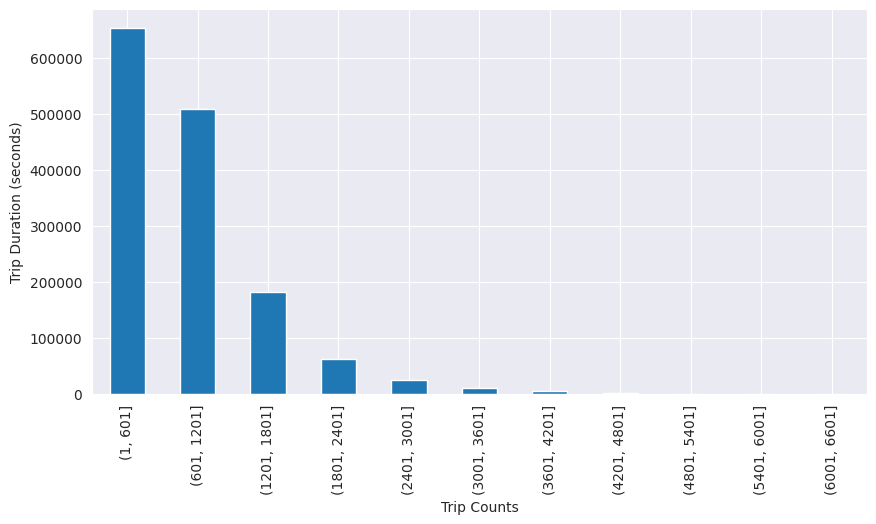

In [ ]:
# we will group the durations in interval of 10 minutes(600 seconds) and see how trip durations are distributed
plt.figure(figsize = (10,5))
NYC_df.trip_duration.groupby(pd.cut(NYC_df.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

In [ ]:
print( NYC_df['trip_duration'].nlargest(10))

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64


In [ ]:
print( NYC_df['trip_duration'].nsmallest(10))

35196     1
207497    1
269418    1
279493    1
285635    1
311745    1
346102    1
346959    1
404610    1
451396    1
Name: trip_duration, dtype: int64


* we have sorted our dataframe that is why we are getting values in a sequence

* We can see that major chunk (99th percentile) of trip duration is completed in 3440 seconds which is nearly 1 hour.

* There are some values with as low as 1 second trip duration, which points towards trips with 0 km distance.

We should get rid of the outliers to maintain the consistency of our data. (Trip durations greater than 5000 seconds as well as less than 60 second are outliers, so we remove them from our data)


In [ ]:
NYC_df = NYC_df.loc[(NYC_df['trip_duration']<=5000) & (NYC_df['trip_duration']>=60)]

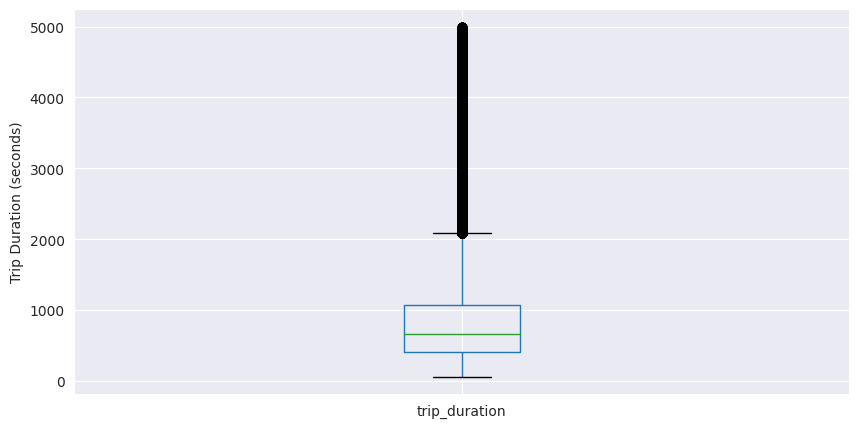

In [ ]:
plt.figure(figsize = (10,5))
NYC_df.boxplot(column = 'trip_duration')
plt.ylabel('Trip Duration (seconds)')
plt.show()

* Major trip durations took between 10-20 mins to complete.



* We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs. Let's move ahead to next feature.

**Trips per Time of Day (Morning, Afternoon, Evening, Late Night)**

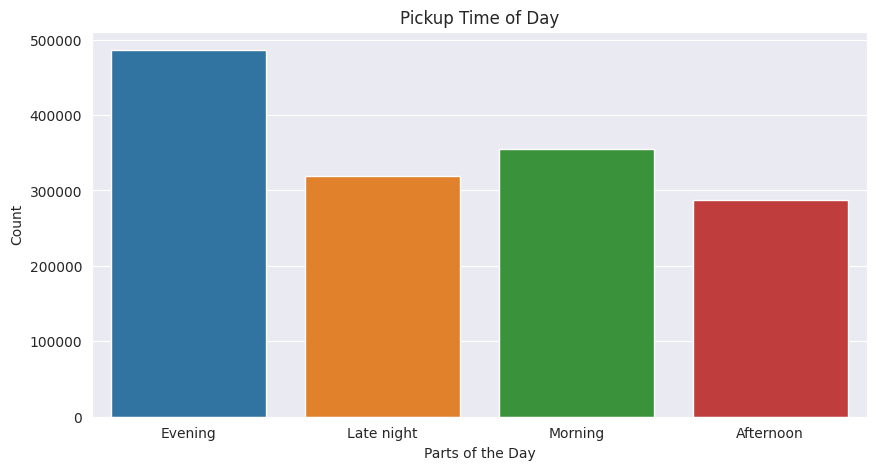

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x="pickup_timeofday",data=NYC_df)
plt.title('Pickup Time of Day')
plt.xlabel('Parts of the Day')
plt.ylabel('Count')
plt.show()

As we saw above, evenings are the busiest.

**Vendor ID**

In [ ]:
NYC_df['vendor_id']

0          2
1          1
2          2
3          2
4          2
          ..
1458639    2
1458640    1
1458641    2
1458642    1
1458643    1
Name: vendor_id, Length: 1446259, dtype: int64

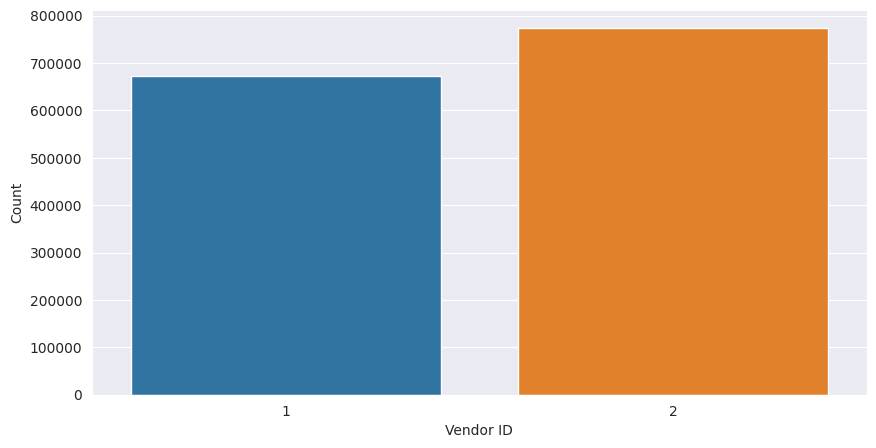

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(data =NYC_df, x= 'vendor_id')
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.show()

We see that there is not much difference between the trips taken by both vendors.

**Passenger count**

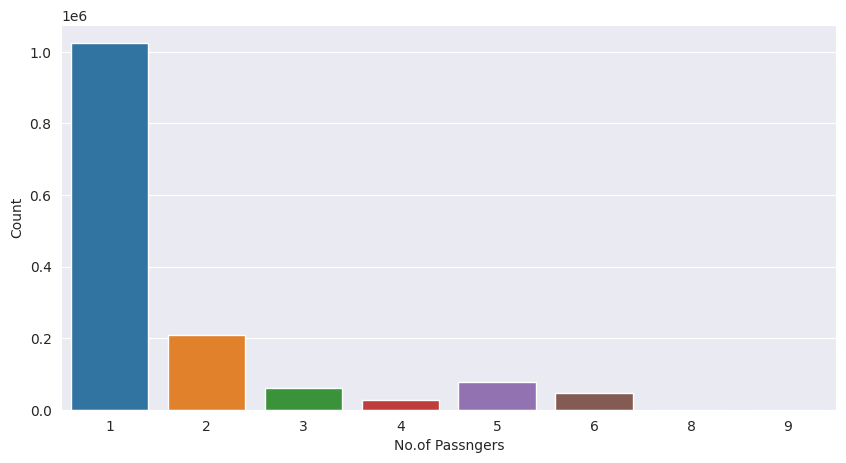

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=NYC_df)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()

Let us remove the rows which have 8 or 9 passenger count.

In [ ]:
NYC_df=NYC_df[NYC_df['passenger_count']<=6]

Let's Visualise it again.

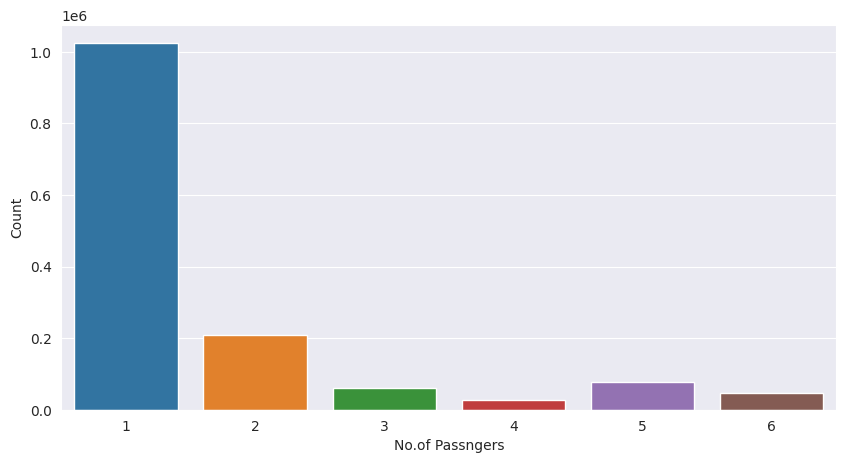

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=NYC_df)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()



*   We see the highest amount of trips was taken by a single passenger.
*   The instance of large group of people travelling together is rare.





**Store and Forward Flag**

In [ ]:
NYC_df['store_and_fwd_flag'].value_counts(normalize=True)

N    0.994564
Y    0.005436
Name: store_and_fwd_flag, dtype: float64



*   We can see that only about 1% of the trip details were stored in the vehicle memory first before sending it to the server.


*   This might have occured because of the GPS or mobile device battery was down when the trip finished.



**Distance**

In [ ]:
NYC_df['distance'].value_counts()

0.000000    4216
0.000424       9
0.000848       5
0.000424       5
0.001273       3
            ... 
5.275778       1
3.343165       1
4.218078       1
8.860892       1
1.134044       1
Name: distance, Length: 1441998, dtype: int64

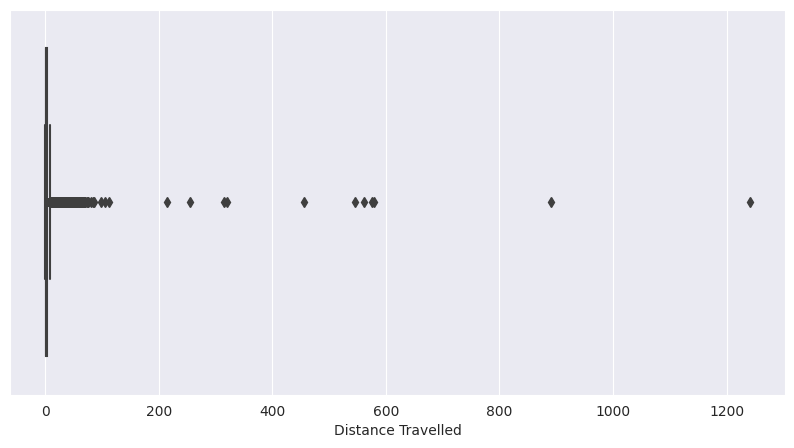

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(x = NYC_df['distance'])

plt.xlabel('Distance Travelled')
plt.show()



*   There are some trips with over 100 km distance.
*   Some of the trips with 0 km distance.

The possible reasons for 0 km trips can be:

*   The dropoff location couldn’t be tracked.
*   The driver deliberately took this ride to complete a target ride number.
*   The passengers or driver cancelled the trip due to some issue.
*   Due to some technical issue in software, etc.

Remove the outliers and update the value




In [ ]:
NYC_df = NYC_df[~(NYC_df.distance > 100)]
NYC_df = NYC_df[~(NYC_df.distance < 1)]

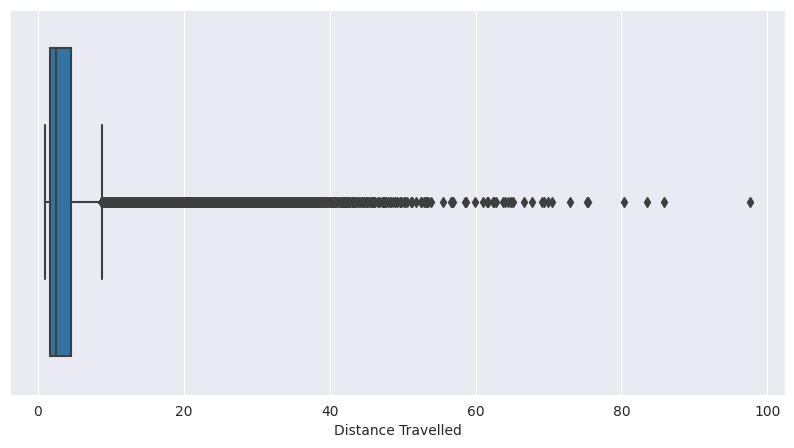

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(x = NYC_df['distance'])
plt.xlabel('Distance Travelled')
plt.show()

**Speed**

In [ ]:
NYC_df['speed'].value_counts()

9.580937     2
11.856445    1
24.973027    1
12.398293    1
10.174207    1
            ..
19.711113    1
13.742299    1
8.855924     1
5.859784     1
20.618974    1
Name: speed, Length: 1209250, dtype: int64

In [ ]:
NYC_df['speed'].nlargest(5)

693299     583.735137
1359910    564.208013
218935     520.505501
500725     424.861414
473439     356.616642
Name: speed, dtype: float64

To understand it better lets plot the boxplot

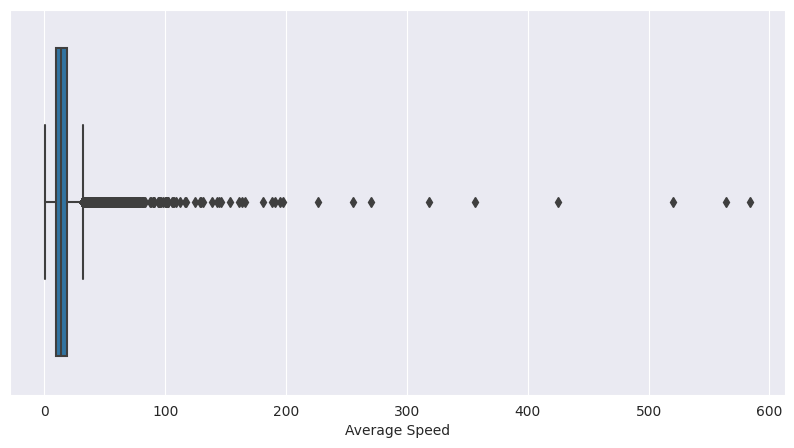

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(x = NYC_df.speed)
plt.xlabel('Average Speed')
plt.show()



*   There are trips that were done at a speed of over 100 km/h.

As per the rule in NYC, the speed limit is 25 mph(approx. 40km/h) in New York City unless another limit is posted. So having average speed of over 60km/h is quite unreasonable.




In [ ]:
NYC_df = NYC_df[~(NYC_df.speed >60)]

In [ ]:
print( NYC_df['speed'].nsmallest(10))

1165873    0.777462
24426      0.825900
1025910    0.877407
1440074    0.900916
1453671    0.913801
440689     0.954780
210725     0.962457
985326     0.988256
623249     0.991219
251672     0.998664
Name: speed, dtype: float64


The smallest speeds show that there are speeds which are less than 1 km/hr for a trip which again is quite unreasonable.

In [ ]:
NYC_df = NYC_df[~(NYC_df.speed <1)]

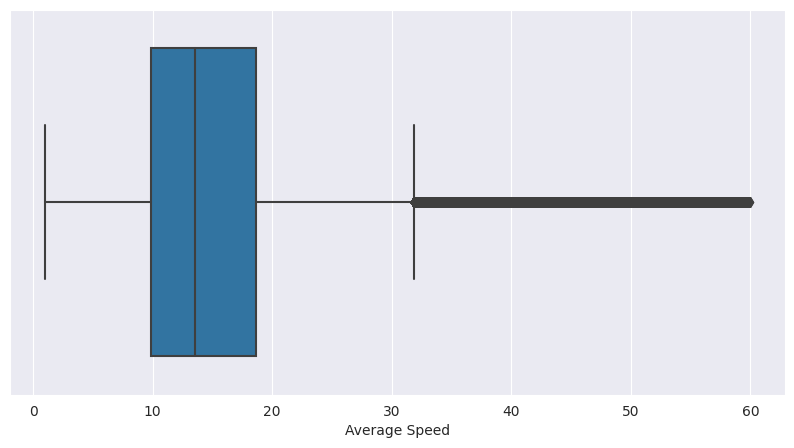

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(x = NYC_df.speed)
plt.xlabel('Average Speed')
plt.show()

Let's take a look at the speed range ditribution with the help of graph.

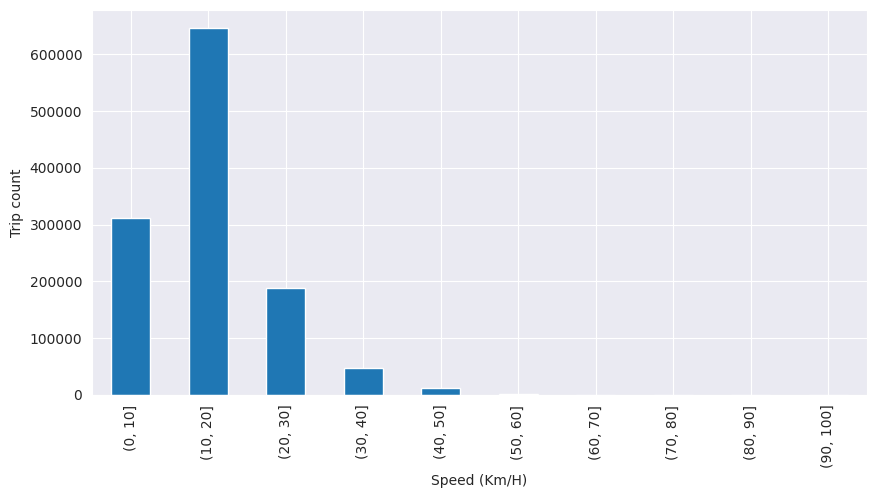

In [ ]:
plt.figure(figsize = (10,5))
NYC_df.speed.groupby(pd.cut(NYC_df.speed, np.arange(0,104,10))).count().plot(kind = 'bar')
plt.ylabel('Trip count')
plt.xlabel('Speed (Km/H)')
plt.show()

Mostly trips are done at a speed range of 10-20 km/h.

**Trips per hour**

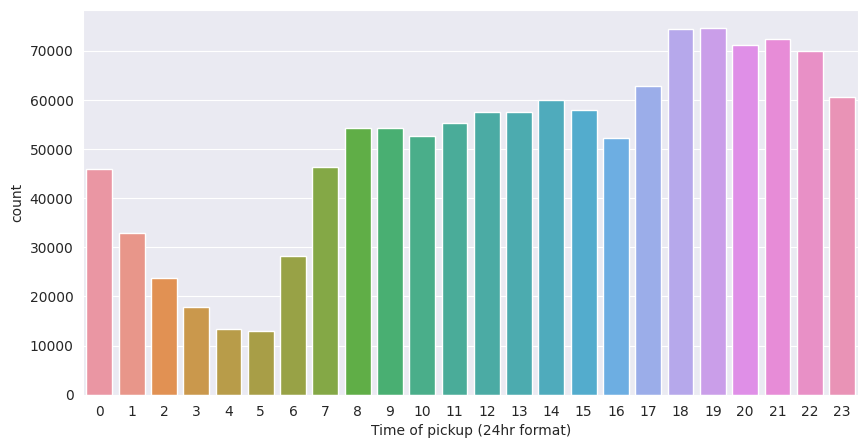

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x = NYC_df.pickup_hour)
plt.xlabel('Time of pickup (24hr format)')
plt.show()

We see the busiest hours are 6:00 pm to 7:00 pm which makes sense as this is the time for people to return home from work.

**Trips per week day**

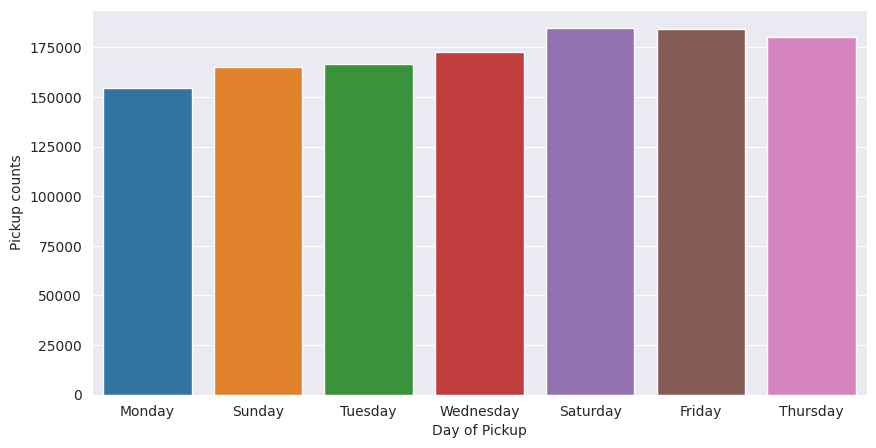

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x = NYC_df.pickup_weekday)
plt.xlabel('Day of Pickup')
plt.ylabel('Pickup counts')
plt.show()

We see Fridays are the busiest days followed by Saturdays. That is probably
because it’s weekend.

**Trips per months**

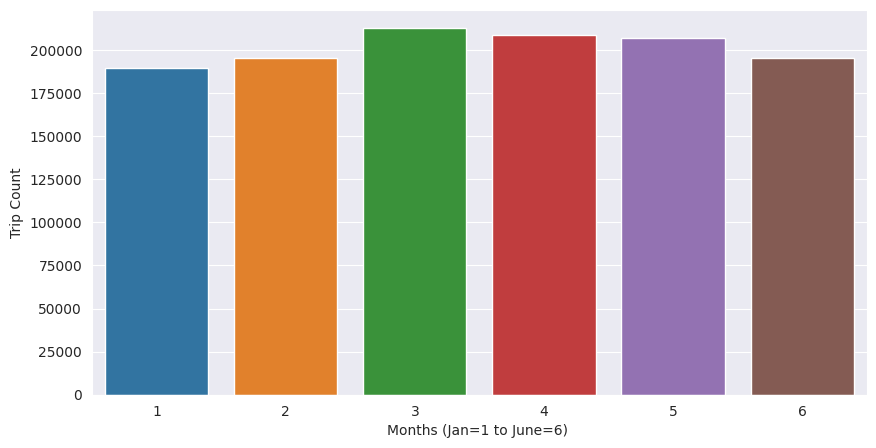

In [ ]:
plt.figure(figsize = (10,5))
sns.countplot(x = NYC_df.month)
plt.ylabel('Trip Count')
plt.xlabel('Months (Jan=1 to June=6) ')
plt.show()

There is not much difference in the number of trips across months. But March sees the highest number of trips among all the other months due to good weather (possible reason).

##**Bivariate Analysis**


---



**Trip Duration per Vendor**

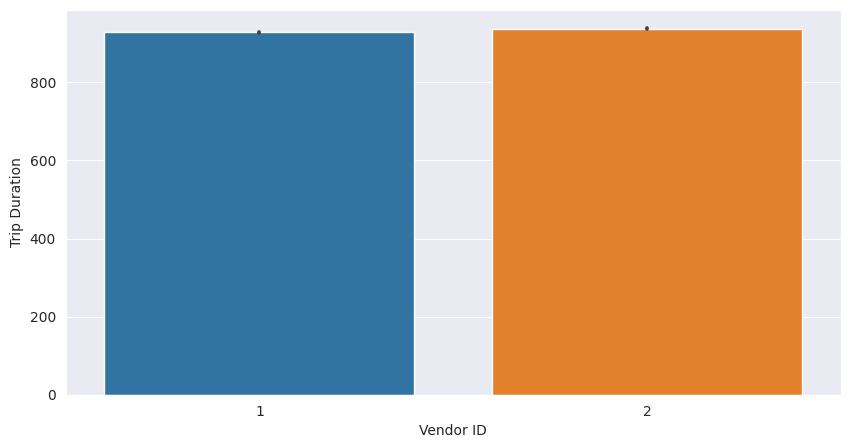

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(y='trip_duration',x='vendor_id',data=NYC_df,estimator=np.mean)
plt.xlabel('Vendor ID')
plt.ylabel('Trip Duration')
plt.show()

Vendor id 2 takes longer trips as compared to vendor 1.

**Trip Duration per Store and Forward Flagt**

<Figure size 1000x500 with 0 Axes>

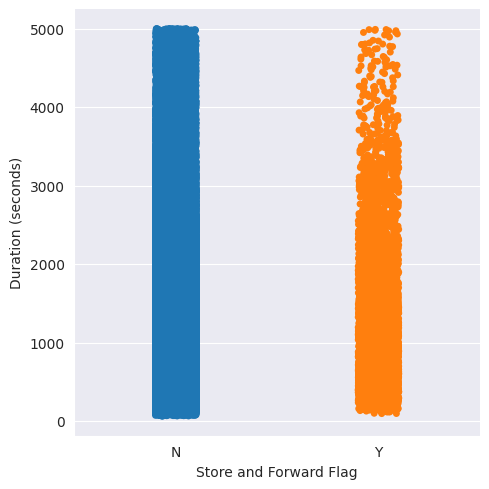

In [ ]:
plt.figure(figsize = (10,5))
sns.catplot(y='trip_duration',x='store_and_fwd_flag',data=NYC_df,kind='strip', hue = 'store_and_fwd_flag')
plt.xlabel('Store and Forward Flag')
plt.ylabel('Duration (seconds)')
plt.show()

There isn't much difference beteen N and Y i.e.stored flags.

**Trip Duration per hour**

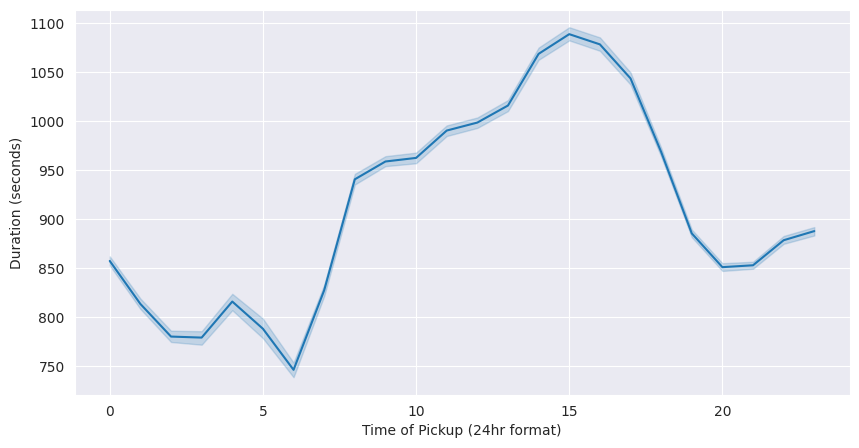

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_hour',y='trip_duration',data=NYC_df)

plt.xlabel('Time of Pickup (24hr format)')
plt.ylabel('Duration (seconds)')
plt.show()

* We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.
* Trip duration is the lowest around 6 am as streets may not be busy.

**Trip duration per weekday**

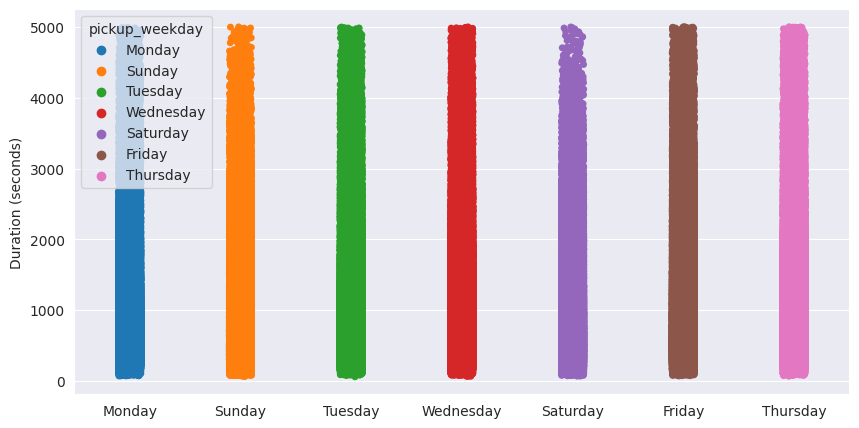

In [ ]:
plt.figure(figsize = (10,5))
sns.stripplot(x='pickup_weekday',y='trip_duration',data=NYC_df, hue = 'pickup_weekday')
plt.ylabel('Duration (seconds)')
plt.xlabel('')
plt.show()

Trip duration on thursday is longest among all days.


**Trip duration per month**

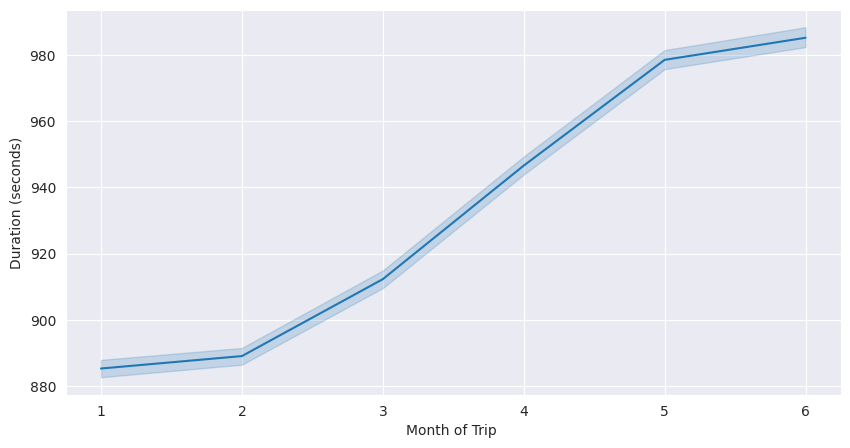

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='month',y='trip_duration', data=NYC_df)
plt.ylabel('Duration (seconds)')
plt.xlabel('Month of Trip ')

plt.show()

* From February, we can see trip duration rising every month.
* There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period.

**Distance and Vendor**

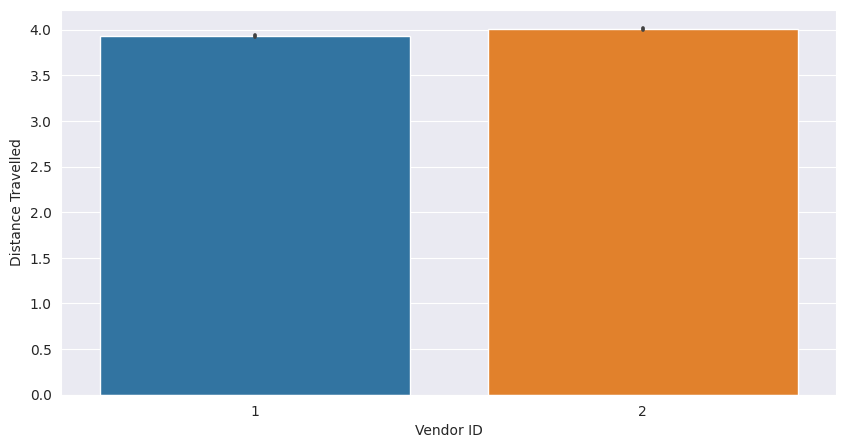

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(y='distance',x='vendor_id',data=NYC_df,estimator=np.mean)
plt.ylabel('Distance Travelled')
plt.xlabel('Vendor ID')
plt.show()

The distribution for both vendors is very similar.

**Distance and Store and Forward Flag**

<Figure size 1000x500 with 0 Axes>

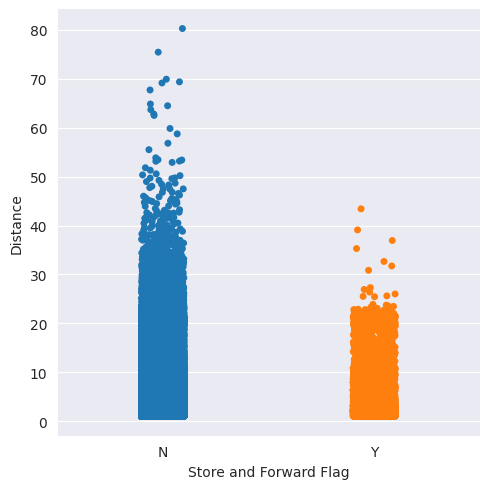

In [ ]:
plt.figure(figsize = (10,5))
sns.catplot(y='distance',x='store_and_fwd_flag',data=NYC_df,kind='strip', hue = 'store_and_fwd_flag')
plt.ylabel('Distance')
plt.xlabel('Store and Forward Flag')
plt.show()

We see for longer distances the trip is not stored.

**Distance and Hour**

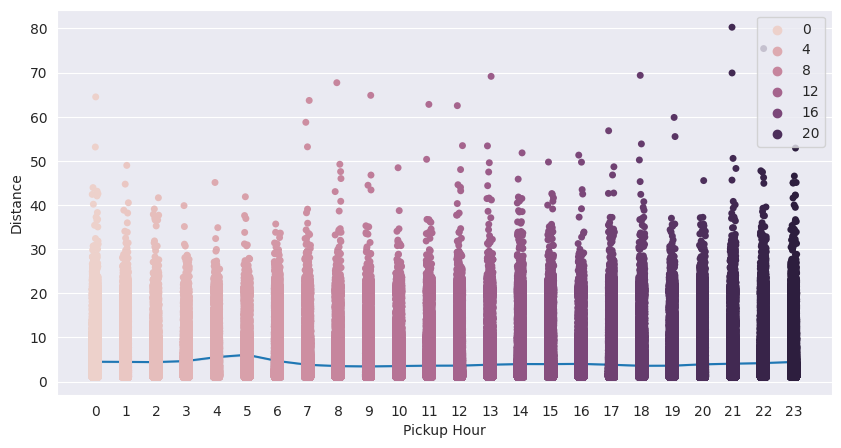

In [ ]:
plt.figure(figsize = (10,5))
sns.stripplot(y='distance',x='pickup_hour',data=NYC_df, hue = 'pickup_hour')
sns.lineplot(y='distance',x='pickup_hour',data=NYC_df)
plt.ylabel('Distance')
plt.xlabel('Pickup Hour')
plt.show()



*   Trip distance is highest during early morning hours for maximum no. of trips, but the random long distnace trips are occuring at nights.
* It is fairly equal from morning till the evening varying around 3 - 3.5 kms.
* It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.




**Distance per Weekday**

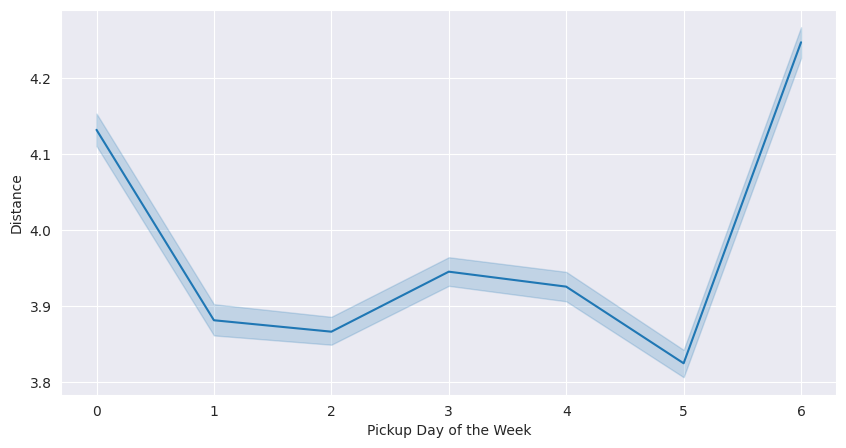

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='pickup_weekday_num', y='distance',data=NYC_df)

plt.ylabel('Distance')
plt.xlabel('Pickup Day of the Week')
plt.show()

So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

**Distance and Month**

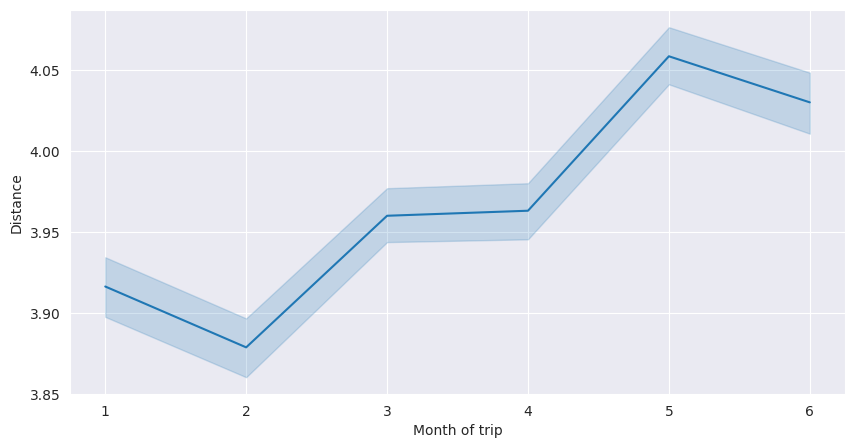

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x='month', y='distance',data=NYC_df)
plt.ylabel('Distance')
plt.xlabel('Month of trip')
plt.show()

As we already saw during trip duration per month, similarly trip distance is lowest in 2nd month and maximum in 5th month.

**Distance and Trip Duration**


We should remove those trips which covered 0 km distance.

In [ ]:
NYC_df = NYC_df[~(NYC_df.distance == 0)]

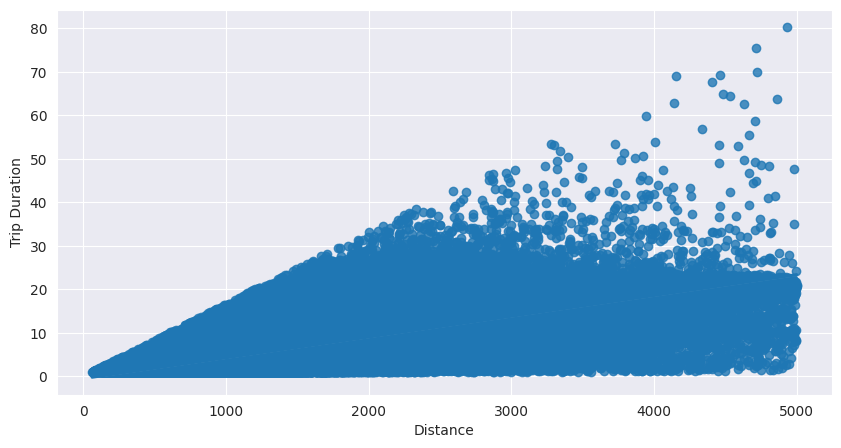

In [ ]:
plt.figure(figsize = (10,5))
sns.regplot(y = NYC_df.distance, x = NYC_df.trip_duration)
plt.ylabel('Trip Duration')
plt.xlabel('Distance')
plt.show()

Initially there is some proper correlation between the distance covered and the trip duration in the graph, but later on it seems a little uncorrelated.

#**Feature Engineering**


---



Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy.

In [ ]:
NYC_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,distance,speed,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,17,3,1.498523,11.856445,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,6,1.805510,9.803673,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,11,1,6.385108,10.822216,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,19,4,1.485501,12.465739,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,13,3,1.188590,9.836608,Afternoon


In [ ]:
NYC_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_weekday', 'dropoff_weekday',
       'pickup_weekday_num', 'pickup_hour', 'month', 'distance', 'speed',
       'pickup_timeofday'],
      dtype='object')

In [ ]:
NYC_df= pd.get_dummies(NYC_df, columns=["store_and_fwd_flag", "pickup_weekday"], prefix=["store_and_fwd_flag",'Day'])


In [ ]:
NYC_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'dropoff_weekday', 'pickup_weekday_num', 'pickup_hour', 'month',
       'distance', 'speed', 'pickup_timeofday', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
       'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [ ]:
#Feature for the Machine learning models
features=['vendor_id','passenger_count','pickup_longitude',
          'pickup_latitude','dropoff_longitude', 'dropoff_latitude',
          'distance','month','trip_duration','pickup_hour',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y', 'Day_Friday',
          'Day_Monday', 'Day_Saturday','Day_Sunday', 'Day_Thursday',
          'Day_Tuesday', 'Day_Wednesday']

In [ ]:
x_features=['vendor_id','passenger_count','pickup_longitude',
          'pickup_latitude','dropoff_longitude', 'dropoff_latitude',
          'distance','month','pickup_hour',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y', 'Day_Friday',
          'Day_Monday', 'Day_Saturday','Day_Sunday', 'Day_Thursday',
          'Day_Tuesday', 'Day_Wednesday']

In [ ]:
NYC_df = NYC_df[features]

In [ ]:
NYC_df['trip_duration_hour']=NYC_df['trip_duration']/3600

In [ ]:
NYC_df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month',
       'trip_duration', 'pickup_hour', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
       'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday',
       'trip_duration_hour'],
      dtype='object')

##**Scaling features and Split Data** 



---





Lets scale our features before scaling the data

In [ ]:
#For Standarization  apply z-score
from scipy.stats import zscore
#Train test split
X = NYC_df[x_features].apply(zscore)[:]
y=NYC_df['trip_duration_hour'][:]

In [ ]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


##**Correlation Analysis**


---



Correlation analysis is a method of statistical evaluation used to study the strength of a relationship between two or more, numerically measured, continuous variables. This analysis is useful when we need to check if there are possible connections between variables. We will utilize Heatmap for our analysis.

##**Heatmap**


---
A heatmap is a graphical representation of data that uses a system of color-coding to represent statistical relationship between different values.

Let's plot the relationship between the features of the Feature selection group first



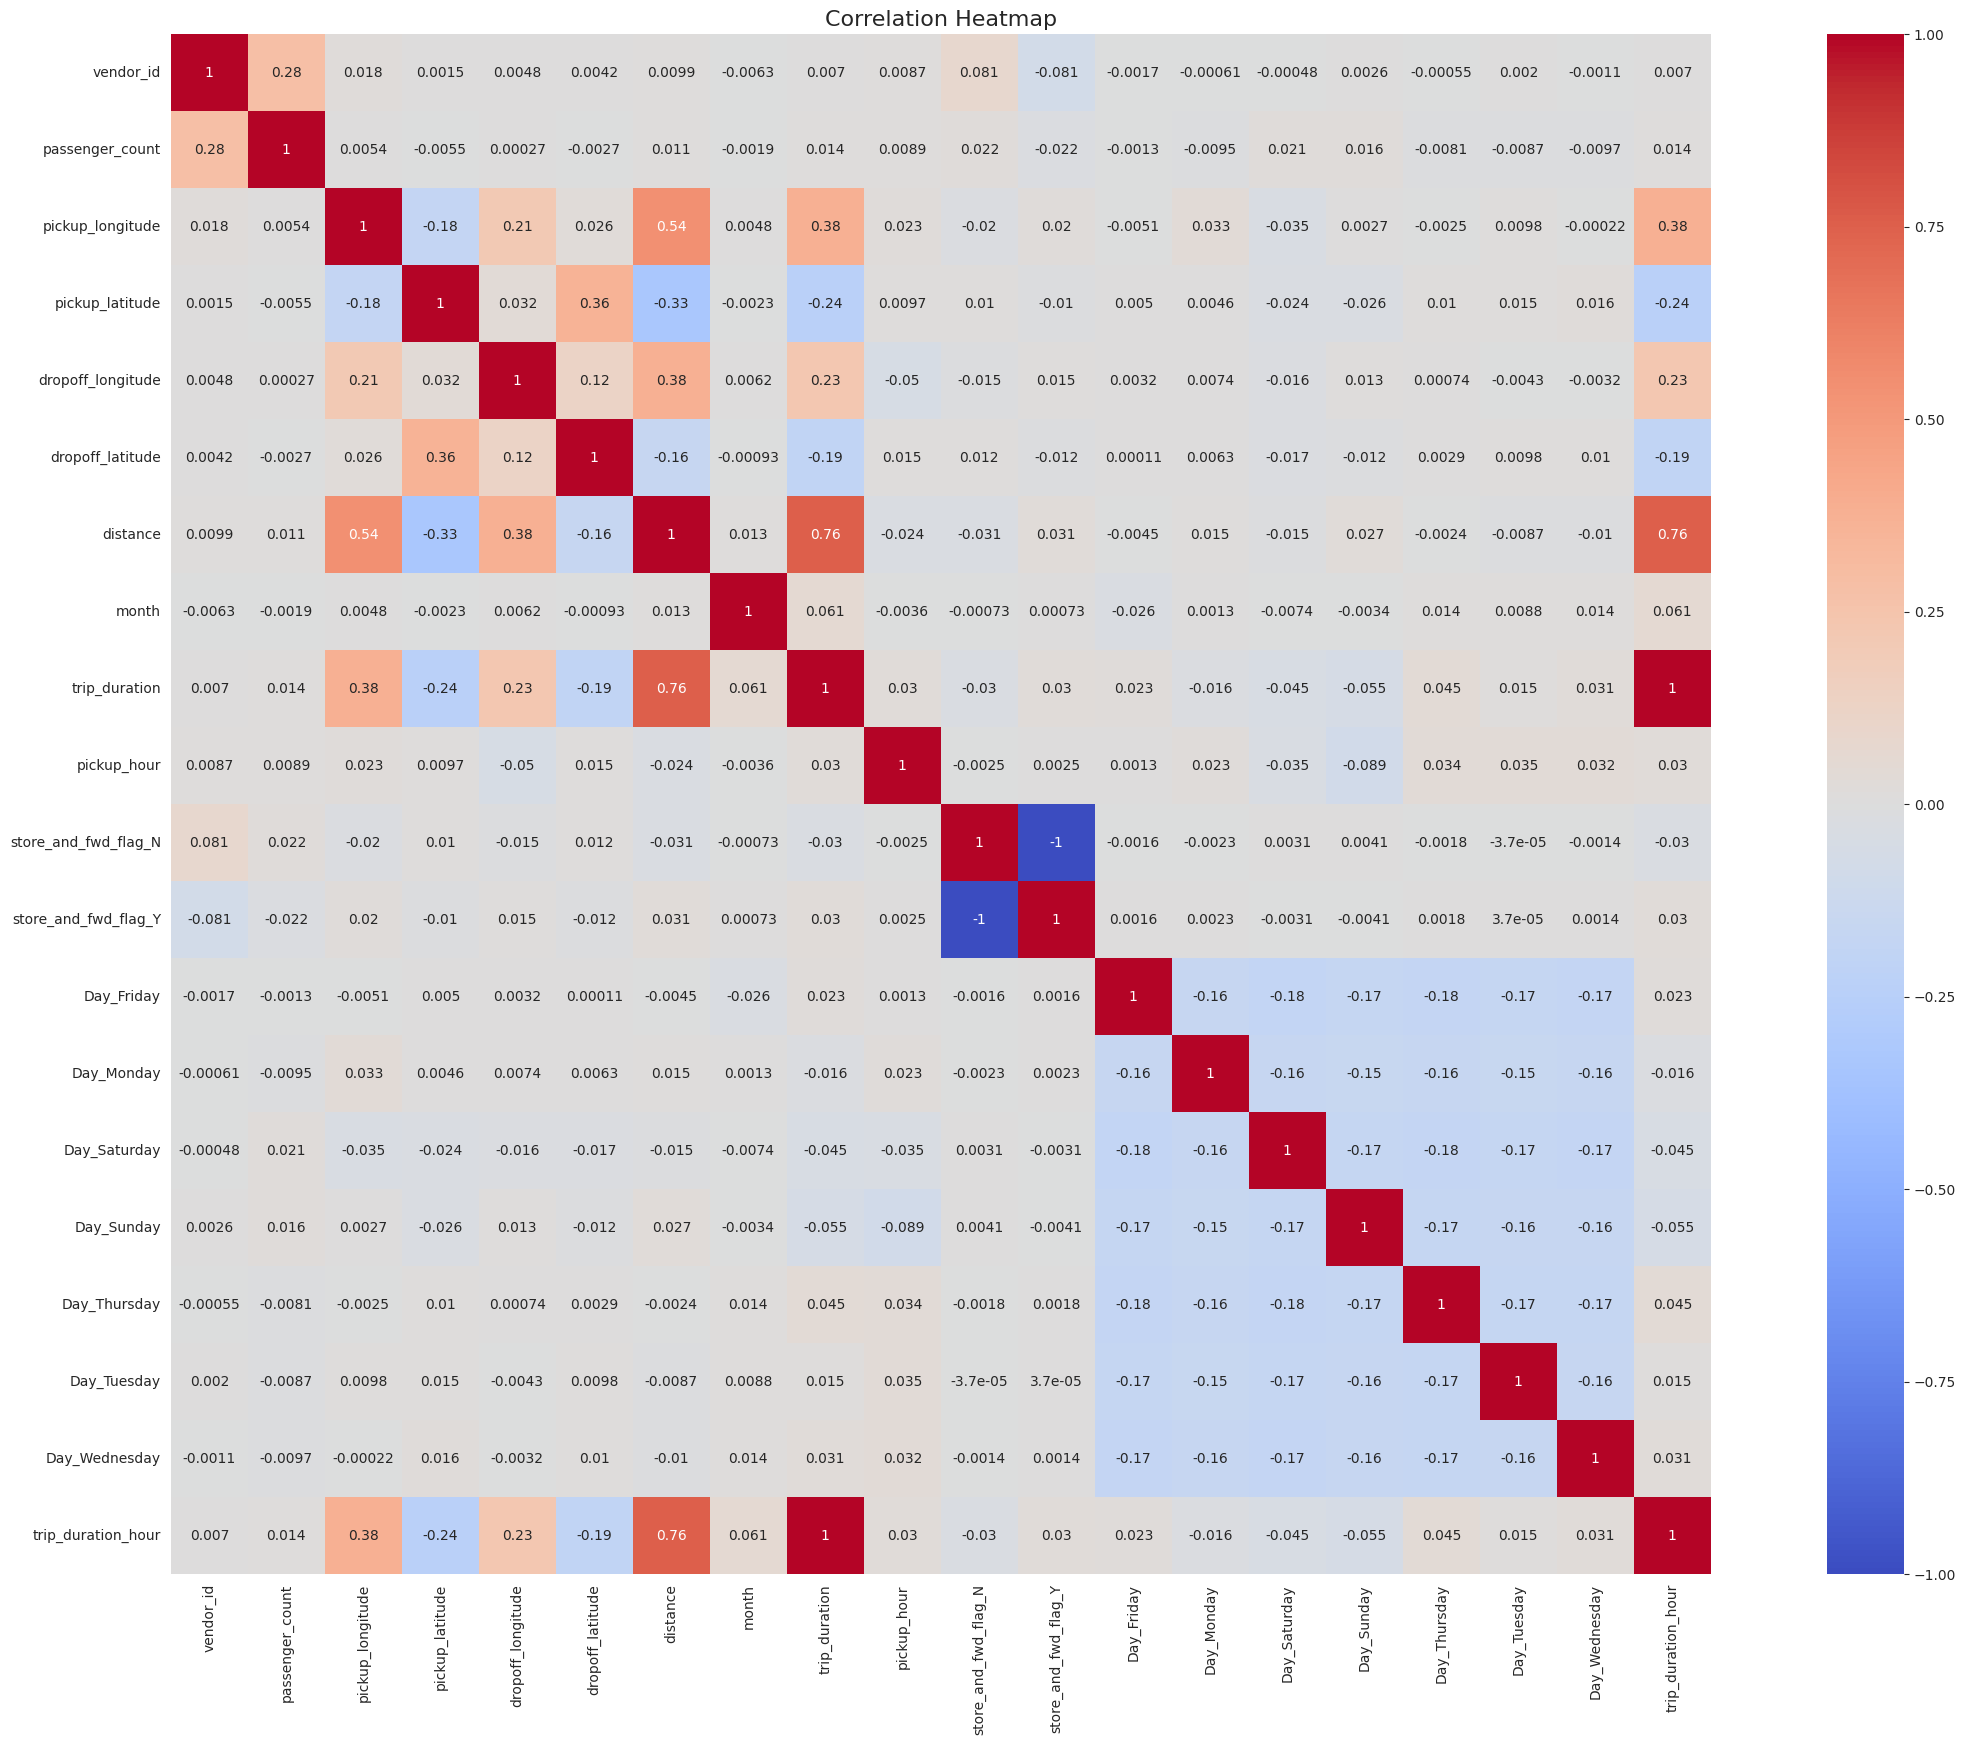

In [ ]:
plt.figure (figsize= (30,20))

sns.heatmap(NYC_df.corr(), cmap='coolwarm', annot=True,vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()



*   We can see store_and_fwd_flag_y and store_and_fwd_flag_N are highly correlated.
* Also they do not affect the target varible i.e. trip_duration_hour much. Hence we should remove these features from our dataset.
* At the same time vendor_id doesn't affect much either so we can remove that as well.




In [ ]:
NYC_df=NYC_df.drop(['store_and_fwd_flag_N', 'store_and_fwd_flag_Y','vendor_id', 'trip_duration'], axis=1)


Let's check numerical features.

In [ ]:
numeric_features= NYC_df.describe().columns

In [ ]:
features= numeric_features.copy()
features= list(features)
features= features[:-1]
features

['passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'distance',
 'month',
 'pickup_hour',
 'Day_Friday',
 'Day_Monday',
 'Day_Saturday',
 'Day_Sunday',
 'Day_Thursday',
 'Day_Tuesday',
 'Day_Wednesday']

In [ ]:
from matplotlib import legend
# Function for evaluation metric for regression
def EvaluationMetric(Xt,yt,yp,disp="on"):
  ''' Take the different set of parameter and prints evaluation metrics '''
  MSE=round(mean_squared_error(y_true=yt,y_pred=yp),4)
  RMSE=(np.sqrt(MSE))
  R2=(r2_score(y_true=yt,y_pred=yp))
  Adjusted_R2=(1-(1-r2_score(yt, yp))*((Xt.shape[0]-1)/(Xt.shape[0]-Xt.shape[1]-1)))
  if disp=="on":
    print("MSE :",MSE,"RMSE :", RMSE)
    print("R2 :",R2,"Adjusted R2 :",Adjusted_R2)

  #Plotting Actual and Predicted Values
  plt.figure(figsize=(18,6))
  plt.plot((yp)[:100]) 
  plt.plot((np.array(yt)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual and Predicted Time Duration')


  
  return (MSE,RMSE,R2,Adjusted_R2) 